# Lab 5 - Embedding Adaptors

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm

import torch

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

349

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [09:26<00:00,  1.62s/it]


In [5]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

## Creating a dataset

In [6]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [7]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1. What is the company's revenue trend over the past few years?
2. How does the company's net income compare to previous years?
3. What are the company's total assets and liabilities?
4. How much cash does the company have on hand?
5. What is the company's current ratio and quick ratio?
6. What is the trend in the company's operating expenses?
7. What is the breakdown of the company's revenue by product or service?
8. How much debt is the company carrying and at what interest rate?
9. What is the company's return on equity and return on assets?
10. How has the company's stock price performed relative to the market?
11. What is the company's dividend policy?
12. How much inventory does the company currently hold?
13. What percentage of the company's revenue is from its top customers?
14. What is the company's capital expenditure plan for the upcoming year?
15. How does the company's financial performance compare to industry peers?


In [8]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [10]:
retrieved_documents[1]

['excluding tac, growth revenue from search and news advertising excluding traffic acquisition costs ( “ tac ” ) paid to bing ads network publishers and news partners summary results of operations ( in millions, except percentages and per share amounts ) 2022 2021 percentage change revenue $ 198, 270 $ 168, 088 18 % gross margin 135, 620 115, 856 17 % operating income 83, 383 69, 916 19 % net income 72, 738 61, 271 19 % diluted earnings per share 9. 65 8. 05 20 % adjusted net income ( non - gaap ) 69, 447 60, 651 15 % adjusted diluted earnings per share ( non - gaap ) 9. 21 7. 97 16 % adjusted net income and adjusted diluted earnings per share ( “ eps ” ) are non - gaap financial measures which exclude the net income tax benefit related to transfer of intangible properties in the first quarter of fiscal year 2022 and the',
 '47 financial statements and supplementary data income statements ( in millions, except per share amounts ) year ended june 30, 2022 2021 2020 revenue : product $ 7

In [9]:
retrieved_documents[0]

['35 reportable segments fiscal year 2022 compared with fiscal year 2021 productivity and business processes revenue increased $ 9. 4 billion or 18 %. • office commercial products and cloud services revenue increased $ 4. 4 billion or 13 %. office 365 commercial revenue grew 18 % driven by seat growth of 14 %, with continued momentum in small and medium business and frontline worker offerings, as well as growth in revenue per user. office commercial products revenue declined 22 % driven by continued customer shift to cloud offerings. • office consumer products and cloud services revenue increased $ 641 million or 11 % driven by microsoft 365 consumer subscription revenue. microsoft 365 consumer subscribers grew 15 % to 59. 7 million. • linkedin revenue increased $ 3. 5 billion or 34 % driven by a strong job market in our talent solutions business and advertising demand in our marketing solutions business.',
 'revenue, classified by significant product and service offerings, was as foll

In [11]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [16]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [15]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [17]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:03<00:00,  4.24s/it]


In [18]:
len(adapter_labels)

150

In [19]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [20]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [21]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


In [ ]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [ ]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [ ]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

In [ ]:
print(f"Best loss: {min_loss.detach().numpy()}") #0.53

In [ ]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [ ]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

import torch

# Example embeddings
adapter_query_embeddings = [
    torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]),
    torch.tensor([6.0, 7.0, 8.0, 9.0, 10.0])
]

# Determine the size of the matrix
mat_size = len(adapter_query_embeddings[0])

# Create a random matrix with gradients
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

print("Matrix size:", mat_size)
print("Adapter matrix:\n", adapter_matrix)


Matrix size: 5
Adapter matrix:
 tensor([[ 0.1234, -0.5678,  1.2345, -0.6789,  0.9876],
         [-1.2345,  0.6789, -0.1234,  1.5678, -0.9876],
         [ 0.5678, -1.6789,  0.1234, -0.5678,  1.2345],
         [-0.6789,  1.2345, -0.5678,  0.1234, -1.6789],
         [ 1.5678, -0.9876,  0.6789, -1.2345,  0.5678]], requires_grad=True)


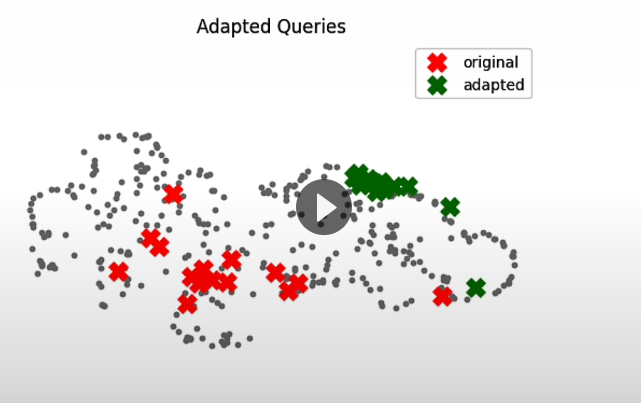